In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression

import warnings
warnings.filterwarnings("ignore")





## Regresion logística Vs Clasificador Bayesiano ingenuo

Compara los métodos de regresión logística y el clasificador bayesiano ingenuo en las siguientes tareas:



En primer lugar se leen los datos 

In [751]:
# Lectura de datos Spam

# Los datos de spam vienen con tipo de datos que no permiten hacer los
# calculos pertinentes para esto se hace arreglos 
#lectura de datos
spam = pd.read_csv("spam.csv")
data_spam = spam.to_numpy()

# Se hace para poner todos los datos como arrays, vienen compactos los datos
x = []
for i in range(len(data_spam)): 
    x.append(np.array([float(i) for i in data_spam[i][0].split()]))
x = np.array(x)

# Se definen los datos y los objetivos
x_data_s = x[:,:-1]
x_target_s = x[:,-1:]

print("Spam")
print("Tamaño de datos = {}, objetivos = {}".format(np.shape(x_data_s),np.shape(x_target_s)))

Spam
Tamaño de datos = (5171, 2000), objetivos = (5171, 1)


In [166]:
# Lectura datos cancer

# Definimos lista con los nombres de las características 
Names = ["ID ","Grosor del tumor","Uniformidad tamaño",
            "forma celula","Adhesion marginal","Tamaño celula epitelial",
            "Nucleos desnudos","Cromatina blanda","Núcleolos normales",
           "Mitosis de celulas","Clase"]
cancer = pd.read_csv("breast-cancer-wisconsin.data",names = Names)
# Eliminamos la columna de ID, no brinda información dado que no se repite
cancer = cancer.drop([cancer.columns[0]],axis = 1)
data_cancer = cancer.to_numpy()


# Para trabajar con uniformidad eliminamos los datos con "?" y asi poder comparar los 
# modelos, el objetivo es poder ver que algoritmo tiene mejor rendimiento 

index = np.where(data_cancer == "?")
data_cancer = np.delete(data_cancer,index,axis=0)
data_cancer[:,5] = data_cancer[:,5].astype(np.float)
data_cancer = data_cancer.astype(np.float)

x_data_c = data_cancer[:,:-1]
x_target_c = data_cancer[:,-1:]

print("Spam")
print("Tamaño de datos = {}, objetivos = {}".format(np.shape(x_data_c),np.shape(x_target_c)))

Spam
Tamaño de datos = (682, 9), objetivos = (682, 1)


Hacemos los modelos para cada uno de los problemas

* Clasificador de spam

In [6]:
# Clasificacion de spam

X_trainNBs, X_testNBs, Y_trainNBs,Y_testNBs = train_test_split(x_data_s,x_target_s,test_size = 0.3)
# Modelo Bayesiano ingenuo
spam_model_NB = MultinomialNB(alpha = 1e-10, class_prior = None, fit_prior=False)
spam_model_NB.fit(X_trainNBs,np.ravel(Y_trainNBs))
print("Rendimiento del modelo Naive Bayes = {:.3f}".format(spam_model_NB.score(X_testNBs,Y_testNBs)))
pred_prob_NB = spam_model_NB.predict(X_testNBs[1:2])

# Modelo de regresión logística
X_trainLRs, X_testLRs, Y_trainLRs,Y_testLRs = train_test_split(x_data_s,x_target_s,test_size = 0.3)
spam_model_LR = LogisticRegression(random_state=0,solver= "newton-cg")
spam_model_LR.fit(X_trainLRs,np.ravel(Y_trainLRs))
print("Rendimiento del modelo Regresión Logistica = {:.3f}".format(spam_model_LR.score(X_testLRs,Y_testLRs)))
pred_prob_LR = spam_model_LR.predict(X_testLRs[1:2])


Rendimiento del modelo Naive Bayes = 0.952
Rendimiento del modelo Regresión Logistica = 0.968


* Clasificador de tumores de Seno 

In [7]:
#Clasificacion de tumores de Seno

# Modelo Bayesiano ingenuo
X_trainNBc, X_testNBc, Y_trainNBc,Y_testNBc = train_test_split(x_data_c,x_target_c,test_size = 0.2)
cancer_model_G = GaussianNB()
cancer_model_G.fit(X_trainNBc,np.ravel(Y_trainNBc))
print("Rendimiento del modelo Naive Bayes = {:.3f}".format(cancer_model_G.score(X_testNBc,Y_testNBc)))
pred_prob_G = cancer_model_G.predict(X_testNBc[1:2])

#Modelo de regresion Logistica
X_trainLRc, X_testLRc, Y_trainLRc,Y_testLRc = train_test_split(x_data_c,x_target_c,test_size = 0.2)
cancer_model_G = LogisticRegression(random_state=0,solver= "liblinear")
cancer_model_G.fit(X_trainLRc,np.ravel(Y_trainLRc))
print("Rendimiento del modelo Naive Bayes = {:.3f}".format(cancer_model_G.score(X_testLRc,Y_testLRc)))
pred_prob_G = cancer_model_G.predict(X_testLRc[1:2])


Rendimiento del modelo Naive Bayes = 0.942
Rendimiento del modelo Naive Bayes = 0.964


Se hace la implementación de el modelo de scikit learn en el caso de regresión logistica para tener una refencia y comparar el modelo que se va a construir y ver si dista mucho del modelo ya programado correctamente

### Regresión logística para la clasificación de spam 

Para este modelo se tienen $N = 5171$ datos recopilados y $M = 2000$ características. A continuación debemos considerar dos clases, es o no spam

debemos encontrar la actualización de los parámetros del modelo a través de la siguiente expresión 

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau} - \eta\nabla_{\omega}E(\vec{\omega})$$


Vamos a escribir la clase que construye el modelo de regresión logística para poder utilizarlo con los dos datos

In [800]:
class LogisticR():
    
    def __init__(self, η = 0.01 , MaxIter = 100, intercept = True ,Error = False):
        self.η = η
        self.MaxIter = MaxIter
        self.intercept = intercept
        self.Error = Error
        #self.l = l
    # Consideracion del punto de corte, añadir los unos a la matriz de diseño
    def Intercept(self,x):
        unos = np.ones((np.shape(x)[0],1))
        Phi = np.concatenate((unos,x),axis = 1)
        return Phi
    
    # Definición de la funcion sigmoide
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def Loss(self,h,y):
        return np.mean(-y*np.log(h)-(1-y)*np.log(1-h))
        
    # Definicion del ajuste
    def fit(self,x,y):
        if self.intercept == True:
            x = self.Intercept(x)
            
        # Inicializacion aleatoria de los pesos 
        self.w = np.random.uniform(0,1,(1,np.shape(x)[1])).T
        if self.Error == True:
            self.l = np.zeros(self.MaxIter)
        
        # Ciclo de optimización de los parámetros 
        for i in range(self.MaxIter):
            z = np.dot(x, self.w)
            h = sigmoid(z)
            g = np.dot(x.T, (h - y)) / y.shape[0]
            self.w = self.w -η*g
            
            if self.Error == True :
                z = np.dot(x, self.w)
                h = sigmoid(z)
                self.l[i] = self.Loss(h,y)
                
            
    # Definicion del calculo de la probabilidad
    def predict_probs(self, x):
            if self.intercept == True:
                return self.sigmoid(np.dot(x, self.w[1:]))
    
    #discriminacion
    def predict(self, x, umbral = 0.5):
            return self.predict_probs(x) >= umbral
        
    def score(self,x,y):
        return sum(self.predict(x) == y)/np.shape(y)[0]

            



Se hace la separacion de los datos para hacer el entrenamiento del modelo

In [808]:
# Separación de los datos
t = 0.7 

x_train = x_data_s[0:int(t*len(x_data_s))]
x_val = x_data_s[int(t*len(x_data_s)):]

y_train = x_target_s[0:int(t*len(x_data_s))]
y_val = x_target_s[int(t*len(x_data_s)):]

Se construye el modelo para hacer el entrenamiento 

In [809]:
model = LogisticR(η = 0.1, MaxIter = 1000, Error = True)
model.fit(x_train,y_train)
model.score(x_val,y_val)

array([0.8189433])

In [810]:
# Separación de los datos
x_data_c = data_cancer[:,:-1]
x_target_c = data_cancer[:,-1:]

t = 0.7 ; v = 1-t


x_train = x_data_c[0:int(t*len(x_data_c))]
x_val = x_data_c[int(t*len(x_data_c)):]

y_train = x_target_c[0:int(t*len(x_data_c))]
y_val = x_target_c[int(t*len(x_data_c)):]

# convertir a unos y ceros los vectores objetivo 
# 2 ----> no tiene cancer corresponde a 0
# 4 ----> tiene cancer corresponde a 1
y_train = np.where(y_train == 2,0,1)
y_val = np.where(y_val == 2,0,1)




In [818]:
model = LogisticR(η = 0.1,MaxIter= 1000,Error = True)
model.fit(x_train,y_train)
model.score(x_val,y_val)

array([0.70731707])

In [819]:
print(model.predict(x_val[2]),y_val[2])

[False] [0]


In [512]:
# Separación de los datos
x_data_c = data_cancer[:,:-1]
x_target_c = data_cancer[:,-1:]

t = 0.7 ; v = 1-t


x_train = x_data_c[0:int(t*len(x_data_c))]
x_val = x_data_c[int(t*len(x_data_c)):]

y_train = x_target_c[0:int(t*len(x_data_c))]
y_val = x_target_c[int(t*len(x_data_c)):]

# convertir a unos y ceros los vectores objetivo 
# 2 ----> no tiene cancer corresponde a 0
# 4 ----> tiene cancer corresponde a 1
y_train = np.where(y_train == 2,0,1)
y_val = np.where(y_val == 2,0,1)




Vamos a construir una clase para poder construir el modelo de regresión logistica


In [745]:
class LogisticR():
    
    def __init__(self, η = 0.01 , MaxIter = 10000, intercept = True ,Error = False):
        self.η = η
        self.MaxIter = MaxIter
        self.intercept = intercept
        self.Error = Error
        #self.l = l
    # Consideracion del punto de corte, añadir los unos a la matriz de diseño
    def Intercept(self,x):
        unos = np.ones((np.shape(x)[0],1))
        Phi = np.concatenate((unos,x),axis = 1)
        return Phi
    
    # Definición de la funcion sigmoide
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def Loss(self,h,y):
        return np.mean(-y*np.log(h)-(1-y)*np.log(1-h))
        
    # Definicion del ajuste
    def fit(self,x,y):
        if self.intercept == True:
            x = self.Intercept(x)
            
        # Inicializacion aleatoria de los pesos 
        self.w = np.random.uniform(0,1,(1,np.shape(x)[1])).T

        self.l = np.zeros(self.MaxIter)
        
        # Ciclo de optimización de los parámetros 
        for i in range(self.MaxIter):
            z = np.dot(x, self.w)
            h = sigmoid(z)
            g = np.dot(x.T, (h - y)) / y.shape[0]
            self.w = self.w -η*g
            
            if self.Error == True :
                z = np.dot(x, self.w)
                h = sigmoid(z)
                self.l[i] = self.Loss(h,y)
                #print("perdida = {:.3f}".format(self.Loss(h,y)))
                
            
    # Definicion del calculo de la probabilidad
    def predict_probs(self, x):
            if self.intercept == True:
                return self.sigmoid(np.dot(x, self.w[1:]))
    
    #discriminacion
    def predict(self, x, umbral = 0.5):
            return self.predict_probs(x) <= umbral
        
    def score(self,x,y):
        return sum(self.predict(x) == y)/np.shape(y)[0]

            

model = LogisticR(η = 0.1,Error = True)
model.fit(x_train,y_train)
model.score(x_val,y_val)

array([0.7804878])

Error = 0.1333828973042116


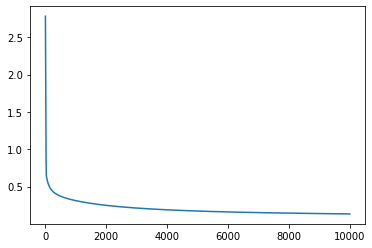

In [746]:
Error = model.l[-1]
plt.plot(model.l)
print("Error = {}".format(Error))

In [747]:
model_spam = LogisticR(η = 0.01)
model

In [631]:
s = 0
for i in range(len(y_val)):
    s+=model.predict(x_val[i],y_val[i])==y_val[i]
s/np.shape(y_val)[0]

array([0.])

In [517]:
unos = np.ones((len(x_train),1))
Phi = np.concatenate((unos,x_train),axis = 1)
w = np.random.uniform(0,1,(1,np.shape(Phi)[1])).T



def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_probs(X, theta):
    return sigmoid(np.dot(X, theta))

def predict(X, theta, threshold=0.5):
    return predict_probs(X, theta) >= threshold



for i in range(10):
    z = np.dot(Phi, w)
    h = sigmoid(z)

    gradient = np.dot(Phi.T, (h - y_train)) / y_train.shape[0]


    lr = 0.01
    w = w - lr * gradient


#print(predict_probs(x_val[0],w[1:]))
s = 0
for i in range(len(y_val)):
    s+=predict(x_val[i],w[1:])==y_val[i]
s/len(y_val)

array([0.2195122])

# 

In [304]:
unos = np.ones((len(x_train),1))
Phi = np.concatenate((unos,x_train),axis = 1)
w = np.random.uniform(0,0.001,(1,np.shape(Phi)[1])).T



Error alcanzado = 284.0


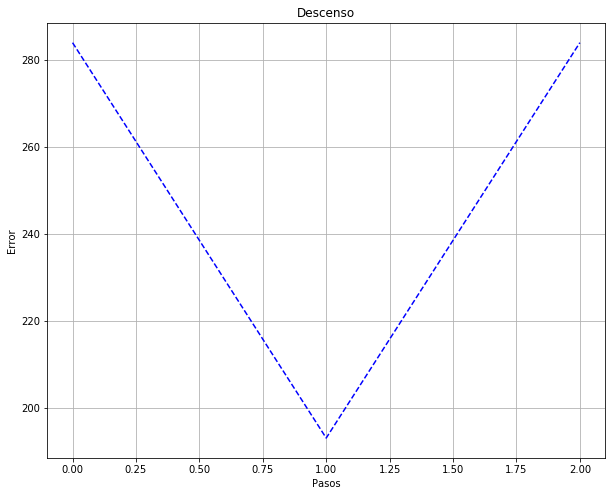

In [317]:
plt.figure(figsize=(10,8))
plt.plot(lost,"b--")
plt.xlabel("Pasos")
plt.ylabel("Error")
plt.title("Descenso", size = 12)
plt.grid(True)
print("Error alcanzado = {}".format(lost[-1]))

In [207]:
sigmoid(w[1:].T@x_val.T)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [201]:
y_val[1]

array([0])

In [226]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if(self.verbose == True and i % 10000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(f'loss: {self.__loss(h, y)} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [232]:
np.shape(x_train)

(477, 9)

In [233]:
np.shape(y_train)

(477, 1)